In [1]:
import llama
from llama import options as opts
from llama.api import enums
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import llama.timing.timer_utils as timer_utils
timer_utils.toggle_timer(True)

In [2]:
import llama.io.loaders
from llama.io.loaders.enums import LoaderType


In [3]:
parent_folder = "/gpfs/dfnt1/test/lamni/cSAXS_e18044_LamNI_201907/"
dat_file_path = os.path.join(parent_folder, "specES1", "dat-files", "tomography_scannumbers.txt")
parent_projection_folder = os.path.join(parent_folder, "analysis")

# # Load data - interactive
options = llama.io.loaders.LamniLoadOptions(
    loader_type=LoaderType.LAMNI_V1,
    selected_experiment_name="unlabeled",
    selected_sequences=[3],
    selected_metadata_list=["512x512_b0_MLc_Niter500_recons"],
    scan_start=2700,
    scan_end=2720,
)

lamni_data = llama.io.loaders.load_data_from_lamni_format(
    dat_file_path=dat_file_path,
    parent_projections_folder=parent_projection_folder,
    n_processes=int(mp.cpu_count() * 0.8),
    options=options,
)


User-provided loading options:
  loader_type: lamni_v1
  selected_experiment_name: unlabeled
  selected_metadata_list: ['512x512_b0_MLc_Niter500_recons']
  selected_sequences: [3]
  scan_start: 2700
  scan_end: 2720
5 scans have one or more projection files.
Use these settings to bypass user-selection on next load:
  selected_experiment_name="unlabeled",
  selected_sequences=[3],
  selected_metadata_list=['512x512_b0_MLc_Niter500_recons'],
  scan_start=2700,
  scan_end=2720,
Loading projections into list...


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:00<00:00, 20.73it/s]


Loading complete. Duration: 0.4477834701538086


In [4]:
# You could update this so it can downsample
projection_array = llama.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
)

Fixing projections dimensions...


  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.38it/s]


Fixing projections dimensions...Completed
Converting list to array...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.22it/s]

Converting list to array..Completed


In [7]:
# Inputs
laminography_angle = 61.108
sample_thickness = 7e-6
center_of_rotation = np.array([1000, 400])
rotation_angle = 46#50#80  # -30
shear_angle = 0  # 1.296

# Convert projection dict to an array
projection_array = llama.io.loaders.utils.convert_projection_dict_to_array(
    lamni_data.projections,
    delete_projection_dict=False,
    pad_with_mode=True,
)

# Set device options for input downsampling, rotation, and shearing
n_gpus = 1
device_options = opts.DeviceOptions(
    device_type=enums.DeviceType.GPU,
    gpu=opts.GPUOptions(
        chunking_enabled=True,
        chunk_length=4,
        n_gpus=n_gpus,
        gpu_indices=(5,),
    ),
)
projection_options = opts.ProjectionOptions(
    experiment=opts.ExperimentOptions(
        laminography_angle=laminography_angle,
        sample_thickness=sample_thickness,
        pixel_size=lamni_data.pixel_size,
    ),
    input_processing=opts.ProjectionTransformOptions(
        rotation=opts.RotationOptions(
            enabled=True,
            angle=rotation_angle,
            device=device_options,
        ),
        shear=opts.ShearOptions(
            enabled=True,
            angle=shear_angle,
            device=device_options,
        ),
        downsample=opts.DownsampleOptions(
            enabled=False,
            scale=1,
            device=device_options,
            use_gaussian_filter=True,
        ),
    ),
)

timer_utils.clear_timer_globals()
# Pin the projections to speed up GPU calculations
projection_array = llama.gpu_utils.pin_memory(projection_array)

complex_projections = llama.ComplexProjections(
    projections=projection_array,
    angles=lamni_data.angles,
    scan_numbers=lamni_data.scan_numbers,
    options=projection_options,
    probe_positions=list(lamni_data.probe_positions.values()),
    probe=lamni_data.probe,
    center_of_rotation=center_of_rotation,
    skip_pre_processing=False,
)

task_options = opts.AlignmentTaskOptions()
task = llama.LaminographyAlignmentTask(
    options=task_options,
    complex_projections=complex_projections,
)

# del projection_array
# complex_projections.scan_numbers = lamni_data.scan_numbers


Fixing projections dimensions...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.77it/s]


Fixing projections dimensions...Completed
Converting list to array...


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.55it/s]


Converting list to array..Completed


image_shear_fft: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 270.03it/s]


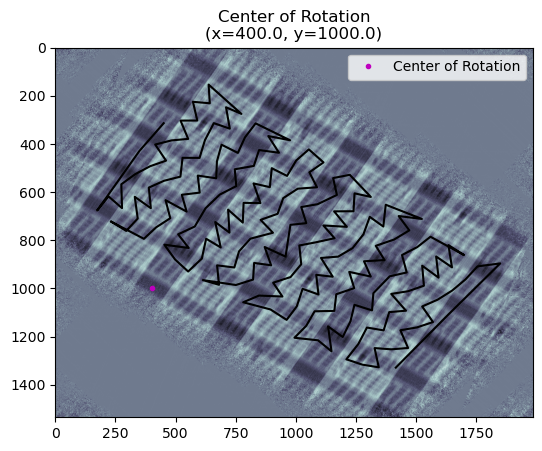

In [8]:
i = 0
task.complex_projections.show_center_of_rotation(plot_sum_of_projections=False, proj_idx=i, show_plot=False)
# plt.plot(center_of_rotation[1], center_of_rotation[0], '*r')
task.complex_projections.probe_positions.plot_positions(index=i, color='k')
plt.show()


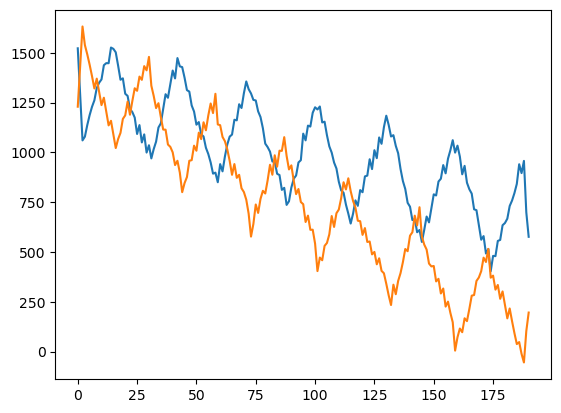

In [25]:
# plt.plot(task.complex_projections.probe_positions.data[0][:, ::-1])
plt.plot(task.complex_projections.probe_positions.data[0][:, :])

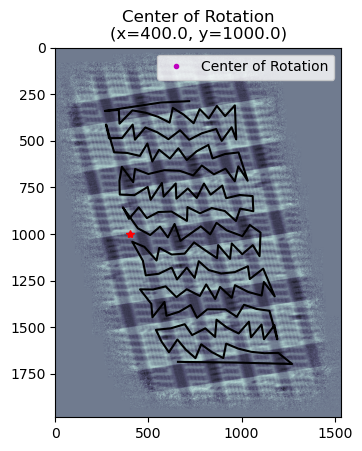

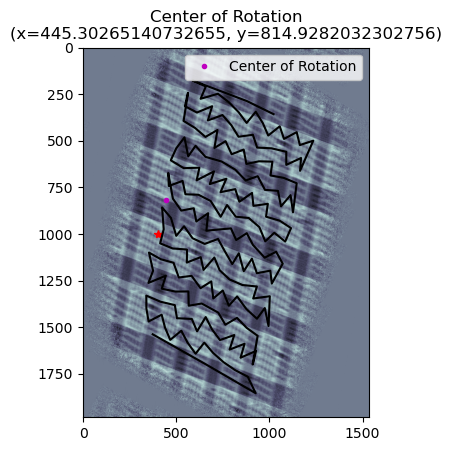

In [15]:
i = 0
task.complex_projections.show_center_of_rotation(plot_sum_of_projections=False, proj_idx=i, show_plot=False)
plt.plot(center_of_rotation[1], center_of_rotation[0], '*r')
task.complex_projections.probe_positions.plot_positions(index=i, color='k')
plt.show()
